In [2]:
%matplotlib inline
import pandas as pd
import datetime
# import pandas_datareader.data as web
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
print(torch.__version__)

1.0.1.post2


In [62]:
reqd_len = 150
channels = 3
class IMUDataset(Dataset):
    def __init__(self, mode = 'test', transform = None):
        if mode == 'train' : 
            self.df = pd.read_csv('../../data/train.csv', header = None)
        elif mode == 'test' : 
            self.df = pd.read_csv('../../data/test.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        x = self.df.iloc[idx : idx + reqd_len, : channels].values
        x = x.astype('float')
        assert(x.shape == (reqd_len, channels))
        return x
        
train_dataset = IMUDataset(mode = 'train')
test_dataset = IMUDataset(mode = 'test')

(128100, 8)
(16200, 8)


In [63]:
batch_size = 1
train_indices = [(i * reqd_len) for i in range(len(train_dataset) // reqd_len)]
test_indices = [(i * reqd_len) for i in range(len(test_dataset) // reqd_len)]

trainloader = DataLoader(train_dataset, batch_size = batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)
trainloader2 = DataLoader(train_dataset, batch_size = 1, sampler = SubsetRandomSampler(train_indices), drop_last = True)
testloader2 = DataLoader(test_dataset, batch_size = 1, sampler = SubsetRandomSampler(test_indices), drop_last = True)

torch.Size([1, 150, 3])


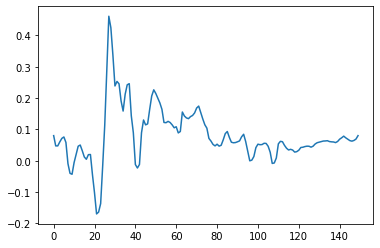

In [64]:
signal = next(iter(trainloader2))
print(signal.shape)
signal = signal.detach().numpy()
signal = np.transpose(signal).reshape(-1)
t = range(150)
plt.plot(t, signal[150 : 300])

In [6]:
# for xavier initialization of network
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
class AutoEncoder(nn.Module) :
    def __init__(self) : 
        super(AutoEncoder, self).__init__()
        # defining layers
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels = 3, out_channels = 2, kernel_size = 5),
            nn.Tanh(),
            nn.Conv1d(in_channels = 2, out_channels = 1, kernel_size = 5),
            nn.Tanh(),
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 5),
            nn.Tanh(),
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 5),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 5),
            nn.Tanh(),
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 5),
            nn.Tanh(),
            nn.ConvTranspose1d(in_channels = 1, out_channels = 2, kernel_size = 5),
            nn.Tanh(),
            nn.ConvTranspose1d(in_channels = 2, out_channels = 3, kernel_size = 5),
        )
        self.classifier = nn.Sequential(
            nn.Linear(134, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5),
            nn.LogSoftmax(dim = 1)
        )
        
    def forward(self, x, encode = False, classify = False) :
        x = torch.transpose(x, 1, 2)
        features = self.encoder(x)
        
        if encode and not classify:
            return features
        elif not encode and classify :
            features = features.view(-1, 134)
            return self.classifier(features)
        else : 
            return self.decoder(features)

In [7]:
Net = AutoEncoder()
Net.apply(init_weights)
if torch.cuda.is_available() : 
    Net = Net.cuda()
    print('Model on GPU')

Model on GPU


In [67]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(Net.parameters(), lr = 5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)

In [68]:
num_epochs = 100
total_step = len(train_dataset) // (batch_size * 150)
train_loss_list = list()
min_loss = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, signals in enumerate(trainloader) :
        if torch.cuda.is_available():
            signals = Variable(signals).cuda().float()
        else : 
            signals = Variable(signals).float()
        
        reconstr = Net.forward(signals)
        signal_ = torch.transpose(signals, 1, 2).float()
        loss = criterion(reconstr, signal_)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 200 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    if train_loss < min_loss : 
        min_loss = train_loss
        torch.save(Net.state_dict() , '../../saved_models/autoencoder7.pt')
        print('Saving model', min_loss)
    
    scheduler.step()

epoch =  0  step =  0  of total steps  854  loss =  0.07928767055273056
epoch =  0  step =  200  of total steps  854  loss =  0.026091355830430984
epoch =  0  step =  400  of total steps  854  loss =  0.06224033236503601
epoch =  0  step =  600  of total steps  854  loss =  0.01593257114291191
epoch =  0  step =  800  of total steps  854  loss =  0.0031944026704877615
Saving model 0.023690393951392146
epoch =  1  step =  0  of total steps  854  loss =  0.005508415400981903
epoch =  1  step =  200  of total steps  854  loss =  0.015234463848173618
epoch =  1  step =  400  of total steps  854  loss =  0.021590713411569595
epoch =  1  step =  600  of total steps  854  loss =  0.014935627579689026
epoch =  1  step =  800  of total steps  854  loss =  0.03449084609746933
Saving model 0.015526781858389967
epoch =  2  step =  0  of total steps  854  loss =  0.03137637674808502
epoch =  2  step =  200  of total steps  854  loss =  0.0015462537994608283
epoch =  2  step =  400  of total steps  

epoch =  20  step =  200  of total steps  854  loss =  0.013569394126534462
epoch =  20  step =  400  of total steps  854  loss =  0.019267113879323006
epoch =  20  step =  600  of total steps  854  loss =  0.0023277646396309137
epoch =  20  step =  800  of total steps  854  loss =  0.004705832805484533
Saving model 0.011553452510336319
epoch =  21  step =  0  of total steps  854  loss =  0.0032939466182142496
epoch =  21  step =  200  of total steps  854  loss =  0.028674380853772163
epoch =  21  step =  400  of total steps  854  loss =  0.004956576973199844
epoch =  21  step =  600  of total steps  854  loss =  0.00789918377995491
epoch =  21  step =  800  of total steps  854  loss =  0.004926878958940506
Saving model 0.01152556481846461
epoch =  22  step =  0  of total steps  854  loss =  0.002492904895916581
epoch =  22  step =  200  of total steps  854  loss =  0.022133395075798035
epoch =  22  step =  400  of total steps  854  loss =  0.0049750106409192085
epoch =  22  step =  60

epoch =  40  step =  200  of total steps  854  loss =  0.01715850830078125
epoch =  40  step =  400  of total steps  854  loss =  0.008738073520362377
epoch =  40  step =  600  of total steps  854  loss =  0.001172004034742713
epoch =  40  step =  800  of total steps  854  loss =  0.00011682789045153186
epoch =  41  step =  0  of total steps  854  loss =  0.011095903813838959
epoch =  41  step =  200  of total steps  854  loss =  0.006067133508622646
epoch =  41  step =  400  of total steps  854  loss =  0.0023247618228197098
epoch =  41  step =  600  of total steps  854  loss =  0.0054428717121481895
epoch =  41  step =  800  of total steps  854  loss =  0.005124663934111595
Saving model 0.011504971578134337
epoch =  42  step =  0  of total steps  854  loss =  0.013523317873477936
epoch =  42  step =  200  of total steps  854  loss =  0.022504040971398354
epoch =  42  step =  400  of total steps  854  loss =  0.007735987659543753
epoch =  42  step =  600  of total steps  854  loss =  

epoch =  60  step =  400  of total steps  854  loss =  0.012073114514350891
epoch =  60  step =  600  of total steps  854  loss =  0.0177749115973711
epoch =  60  step =  800  of total steps  854  loss =  0.002090820111334324
Saving model 0.011503719573619358
epoch =  61  step =  0  of total steps  854  loss =  0.023346420377492905
epoch =  61  step =  200  of total steps  854  loss =  0.009028955362737179
epoch =  61  step =  400  of total steps  854  loss =  0.005456923972815275
epoch =  61  step =  600  of total steps  854  loss =  0.015229863114655018
epoch =  61  step =  800  of total steps  854  loss =  0.024626905098557472
Saving model 0.011503241967331091
epoch =  62  step =  0  of total steps  854  loss =  0.01849706657230854
epoch =  62  step =  200  of total steps  854  loss =  0.007739487569779158
epoch =  62  step =  400  of total steps  854  loss =  0.0199696384370327
epoch =  62  step =  600  of total steps  854  loss =  0.014010291546583176
epoch =  62  step =  800  of 

epoch =  80  step =  600  of total steps  854  loss =  0.017322827130556107
epoch =  80  step =  800  of total steps  854  loss =  0.017402654513716698
Saving model 0.01150311652344045
epoch =  81  step =  0  of total steps  854  loss =  0.029184039682149887
epoch =  81  step =  200  of total steps  854  loss =  0.016172584146261215
epoch =  81  step =  400  of total steps  854  loss =  0.021106954663991928
epoch =  81  step =  600  of total steps  854  loss =  0.007017997093498707
epoch =  81  step =  800  of total steps  854  loss =  0.0009899650467559695
Saving model 0.011503071078277784
epoch =  82  step =  0  of total steps  854  loss =  0.00546332448720932
epoch =  82  step =  200  of total steps  854  loss =  0.011079249903559685
epoch =  82  step =  400  of total steps  854  loss =  0.04235585406422615
epoch =  82  step =  600  of total steps  854  loss =  0.02057507261633873
epoch =  82  step =  800  of total steps  854  loss =  0.0037358710542321205
Saving model 0.01150307000

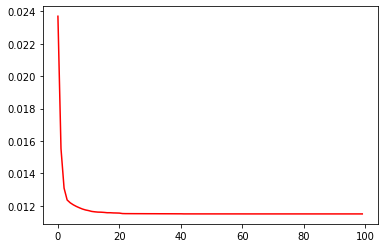

In [69]:
j = range(100)
plt.plot(j, train_loss_list, 'r')

### Verifying that AutoEncoder has not learnt the identity function

In [70]:
Net = AutoEncoder()
Net.load_state_dict(torch.load('../../saved_models/autoencoder7.pt'))
Net = Net.eval()
print(Net.encoder[0].weight)
print(Net.encoder[2].weight)
print(Net.encoder[4].weight)
print(Net.encoder[6].weight)
print(Net.decoder[0].weight)
print(Net.decoder[2].weight)
print(Net.decoder[4].weight)
print(Net.decoder[6].weight)

Parameter containing:
tensor([[[ 9.7451e-02, -2.4145e-01,  1.3841e-01,  9.6034e-02, -8.9985e-02],
         [ 2.0021e-02,  1.0986e-02, -9.3586e-02, -1.7049e-01,  2.7491e-01],
         [-4.2521e-02, -6.9134e-02,  5.6894e-02,  3.6201e-01, -5.4145e-02]],

        [[ 3.6566e-02,  3.4428e-02,  1.1409e-05, -7.1751e-02,  1.0652e-01],
         [-2.1510e-02,  1.0396e-01, -2.7813e-01, -6.9494e-02,  2.2774e-01],
         [-8.9937e-02, -5.9715e-02,  1.7334e-01, -2.1512e-01, -8.2210e-03]]],
       requires_grad=True)
Parameter containing:
tensor([[[ 0.1077,  0.3916,  0.3757, -0.0391, -0.0559],
         [-0.2823, -0.2966, -0.0455, -0.1086,  0.0238]]], requires_grad=True)
Parameter containing:
tensor([[[ 0.1409, -0.2345, -0.3961, -0.5349,  0.2329]]], requires_grad=True)
Parameter containing:
tensor([[[-0.4022,  0.5442,  0.6559,  0.1688, -0.1730]]], requires_grad=True)
Parameter containing:
tensor([[[-0.0287, -0.4649, -1.1180, -0.2686,  0.0104]]], requires_grad=True)
Parameter containing:
tensor([[[ 0.

### Checking reconstruction quality visually
Works correctly now!

1st and 2nd axis loss :  0.01776733249425888
3rd axis loss :  0.0037095474544912577
0.013081403449177742


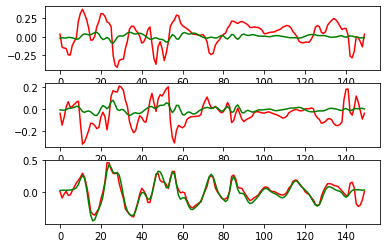

In [77]:
Net = Net.eval()
x = next(iter(testloader2))
y = Net.forward(x.float())
loss = criterion(torch.transpose(x, 1, 2).float(), y)

x1 = torch.transpose(x, 1, 2)[0][ : 2].float()
y1 = y[0][ : 2].float()
print('1st and 2nd axis loss : ', criterion(y1, x1).item())
x2 = torch.transpose(x, 1, 2)[0][2].float()
y2 = y[0][2].float()
print('3rd axis loss : ', criterion(y2, x2).item())

x = torch.transpose(x, 1, 2)
x = x.detach().numpy()
y = y.detach().numpy()

fig, ax = plt.subplots(3, 1)
ax[0].plot(x[0][0], 'r')
ax[0].plot(y[0][0], 'g')
print(loss.item())
ax[1].plot(x[0][1], 'r')
ax[1].plot(y[0][1], 'g')
ax[2].plot(x[0][2], 'r')
ax[2].plot(y[0][2], 'g')

### Now training the classifier

In [3]:
reqd_len = 150
channels = 3
class IMUDataset(Dataset):
    def __init__(self, mode = 'test', transform = None):
        if mode == 'train' :
            self.df = pd.read_csv('../../data/train.csv', header = None)
        elif mode == 'test' :
            self.df = pd.read_csv('../../data/test.csv', header = None)
        elif mode == 'val' :
            self.df = pd.read_csv('../../data/val.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        y = self.df.iloc[idx : idx + reqd_len, 3 : ].values
        ind = np.argmax(np.sum(y, axis = 0))
        label = np.zeros_like(self.df.iloc[0, 3 : ].values)
        label = label.astype('float')
        label[ind] = 1
        x = self.df.iloc[idx : idx + reqd_len, : channels].values
        x = x.astype('float')
        x = x.reshape(reqd_len, channels)
        assert(x.shape == (reqd_len, channels))
        assert(label.shape == (5, ))
        return x, label
        
trainset = IMUDataset(mode = 'train')
valset = IMUDataset(mode = 'val')
testset = IMUDataset(mode = 'test')

(128100, 8)
(15900, 8)
(16200, 8)


In [4]:
train_batch_size = 8
batch_size = 8
train_indices = [(i * reqd_len) for i in range(len(trainset) // reqd_len)]
val_indices = [(i * reqd_len) for i in range(len(valset) // reqd_len)]
test_indices = [(i * reqd_len) for i in range(len(testset) // reqd_len)]

trainloader = DataLoader(trainset, batch_size = train_batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)
valloader = DataLoader(valset, batch_size = batch_size, sampler = SubsetRandomSampler(val_indices), drop_last = True)
testloader = DataLoader(testset, batch_size = batch_size, sampler = SubsetRandomSampler(test_indices), drop_last = True)

In [8]:
# Loading autoencoder saved model
Net = AutoEncoder()
Net.load_state_dict(torch.load('../../saved_models/autoencoder7.pt'), strict = False)
# # freezing encoder and decoder layers
Net.encoder[0].requires_grad = False
Net.encoder[2].requires_grad = False
Net.decoder[0].requires_grad = False
Net.decoder[2].requires_grad = False
Net = Net.cuda()

In [9]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3)

In [10]:
num_epochs = 30
total_step = len(trainset) // (train_batch_size * 150)
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().float()
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).float()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)
        print(target.shape)

        y_pred = Net.forward(images, classify = True)
        print(y_pred.shape)
        
        loss = criterion(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().float()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).float()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net.forward(images, classify = True)
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), 'autoencoder_classifier2.pt')

torch.Size([8])
torch.Size([8, 5])
epoch =  0  step =  0  of total steps  106  loss =  1.6012157201766968
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
epoch =  0  step =  20  of total steps  106  loss =  1.4966932535171509
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
t

KeyboardInterrupt: 

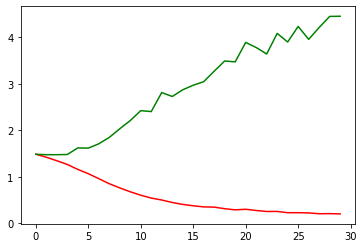

In [53]:
j = np.arange(30)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [54]:
def _get_accuracy(dataloader, Net):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = Variable(images).float()
        labels = Variable(labels).float()

        outputs = Net(images, classify = True)
    
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.numpy()
        pred_ind = pred_ind.data.numpy()
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net = Net.cpu().eval()
# _get_accuracy(trainloader)

In [55]:
print(_get_accuracy(trainloader, Net))
print(_get_accuracy(testloader, Net))
print(_get_accuracy(valloader, Net))

0.9610849056603774
0.28846153846153844
0.28846153846153844


The symmetrical fully convolutional autoencoder doesn't work well. So, next we try using an asymmetrical autoencoder (asymmetrical since it will only have maxpool in encoder) (TODO)

In [32]:
# TODO - (MEDIUM-PRIORITY)
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # defining layers
        self.conv1 = nn.Conv1d(3, 10, 3)
        self.mp = nn.MaxPool1d(2, 2)
        
        self.dconv1 = nn.ConvTranspose1d(10, 3, 3)
        nn.init.xavier_uniform_(self.conv1.weight, gain = nn.init.calculate_gain('relu'))
        
    def forward(self, signal):
        signal = signal.view(-1, 150 * 3)
        out = F.relu(self.fc1(signal))
        out = F.relu(self.fc2(out))
        out = F.log_softmax(self.fc3(out), dim = 1)
        return out

Net = AutoEncoder()
if torch.cuda.is_available():
    print('Model on GPU')
    Net = Net.cuda()